# VAE using the reparametrization trick

## Imports and enabling of eager execution

In [1]:
import json
from collections import namedtuple
from functools import partial
import itertools
import warnings
import os
import time
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import imageio
from IPython import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from functional import seq
from pathlib import Path
from functools import reduce

from importlib import reload # for debugging and developing, optional

import tensorflow as tf
import tensorflow.contrib as tfc
import tensorflow.contrib.eager as tfe
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow_probability as tfp

# for the KL-loss explosion problem
tf.enable_eager_execution()
# we currently handle them ourselves. but with this, it will throw an error before we can apply the fix
tfe.seterr(inf_or_nan='raise')

# otherwise TF will print soooo many warnings
warnings.filterwarnings('ignore', '.*FutureWarning.*np.complexfloating.*')

from som_vae.helpers.tensorflow import _TF_DEFAULT_SESSION_CONFIG_
import som_vae.helpers.tensorflow as tf_helpers
sess = tf.InteractiveSession(config=_TF_DEFAULT_SESSION_CONFIG_)
tf.keras.backend.set_session(sess)

from som_vae.settings.config import SetupConfig, RunConfig
from som_vae import data_loading
from som_vae import settings
from som_vae import preprocessing
from som_vae.helpers.misc import extract_args, chunks, foldl, if_last
from som_vae.helpers.jupyter import fix_layout, display_video
from som_vae.settings import config, skeleton
from som_vae.settings import data as SD
from som_vae.helpers import video, plots, misc, jupyter
from som_vae import preprocessing
from som_vae.helpers.logging import enable_logging

W0612 03:07:31.225786 140501472360256 deprecation_wrapper.py:119] From /home/sam/proj/epfl/neural_clustering_vae/som_vae/helpers/tensorflow.py:5: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [2]:
jupyter.fix_layout()

## Constants (Settings)

In [3]:
# all those experiments and data will be used
#from som_vae.settings import config
#print(f"this is the main experiment, study, and fly id: {config.full_experiment_id()}.\n\nloadable experiments. there is a blacklist below.")
#!ls $config.__EXPERIMENT_ROOT__

In [4]:
# if you want to see the flys as well, or just more information
# !tree -L 2 $config.__EXPERIMENT_ROOT__

## Loading of 2d positional data

In [5]:
#if not run_config['use_all_experiments']:
#    frames_idx_with_labels = preprocessing.get_frames_with_idx_and_labels(settings.data.LABELLED_DATA)
#    frames_of_interest = ~frames_idx_with_labels['label'].isin([settings.data._BehaviorLabel_.REST])

In [6]:
# TODO form a wrapper around the used data, experiments (the ids), data, normalisation factor, images, ... a namedtuple should do the trick
#if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#    if run_config['use_all_experiments']:
#        all_experiments = [e for e in experiments_from_root() if e.study_id not in _EXPERIMENT_BLACK_LIST_ or config.get_experiment_id(e) in _FLY_BLACK_LIST_]
#        joint_positions, normalisation_factors = preprocessing.get_data_and_normalization(all_experiments, normalize_data=True)
#    else:
#        joint_positions, normalisation_factors = preprocessing.get_data_and_normalization(settings.data.EXPERIMENTS, normalize_data=True)
#
#        images_paths_for_experiments = settings.data.EXPERIMENTS.map(lambda x: (x, config.positional_data(x)))\
#                                               .flat_map(lambda x: [(x[0], config.get_path_for_image(x[0], i)) for i in range(x[1].shape[1])])\
#                                               .to_list()
#
#        if len(frames_of_interest) != len(joint_positions):
#            warnings.warn('There is a bug here. The number of images and number of data points to NOT align.')
#            frames_of_interest = np.where(frames_of_interest[:len(joint_positions)])[0]
#        
#        joint_positions = joint_positions[frames_of_interest[:len(joint_positions)]]
#        frames_idx_with_labels = frames_idx_with_labels.iloc[frames_of_interest]
#        images_paths_for_experiments =  np.array(images_paths_for_experiments)[frames_of_interest].tolist()

## loading of angle-data

In [7]:
setup_cfg = SetupConfig()
run_cfg = RunConfig.ANGLE_3D()

frame_data, frame_labels = data_loading.load_labelled_data(run_config=run_cfg, setup_config=setup_cfg)

huh?? something odd with Experiment(study_id='180921_aDN_CsCh', fly_id='Fly6', experiment_id='003_SG1'): /home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly6/003_SG1/behData/images: [Errno 2] No such file or directory: '/home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly6/003_SG1/behData/images'
huh?? something odd with Experiment(study_id='180921_aDN_CsCh', fly_id='Fly3', experiment_id='001_SG1'): /home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly3/001_SG1/behData/images: [Errno 2] No such file or directory: '/home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly3/001_SG1/behData/images'
huh?? something odd with Experiment(study_id='180921_aDN_CsCh', fly_id='Fly6', experiment_id='001_SG1'): /home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/Fly6/001_SG1/behData/images: [Errno 2] No such file or directory: '/home/sam/proj/epfl/neural_clustering_data/experiments/180921_aDN_CsCh/

In [8]:
frame_data, frame_labels, selected_columns, normalisation_factors = preprocessing.preprocess_3d_angle_data(frame_data, frame_labels, **run_cfg.value('angle_3d_params', 'preprocessing'))

In [9]:
#if run_config['data_type'] == _DATA_TYPE_3D_ANGLE_ and run_config['use_all_experiments']:
#    all_experiments = [e for e in experiments_from_root() if (e.study_id not in _EXPERIMENT_BLACK_LIST_) and (e.key not in _FLY_BLACK_LIST_)]
#    # `per_experiment` is a shitty parameter name, the data is not normalised and return per experiment.
#    loading_kwargs = {'dimensions': '3d', 'return_with_experiment_id': True}
#    angle_data_raw = [(exp_id, SD.convert_3d_to_angle(d)) for exp_id, d in preprocessing.get_data_and_normalization(all_experiments, **loading_kwargs)]
#
#    # takes for ever to render, if you want to see this, please run it yourself
#    #plots.plot_distribution_of_angle_data(angle_data_raw, run_config=run_config);
#
#    exp_ids, angle_data  = zip(*angle_data_raw)
#    angle_data = np.vstack(angle_data)
#    selected_cols = np.where(np.var(angle_data, axis=0) > 0.0)[0]
#    joint_positions = angle_data[:, selected_cols]

In [10]:
# will generate a huge plot and take about 6min to run...
#plots.plot_distribution_of_angle_data(angle_data_raw, run_config=run_config);

In [11]:
#all_experiments = experiments_from_root()
#print(len(all_experiments))
#
#pos_data = preprocessing.get_data_and_normalization(all_experiments, per_experiment=True)
#
#norm_pos_data, norm_pos_data_params = zip(*[preprocessing.normalize(p) for p in pos_data])
#experiment_lengths = [len(p) for p in norm_pos_data] # for applying the right normalization factors
#norm_pos_data = np.vstack(norm_pos_data)
#
#print(f"in total we have {len(all_experiments)} experiments, but only {len(experiment_lengths)} are usable right now")
#
#norm_pos_data_embedded = TSNE(n_components=2, random_state=42).fit_transform(norm_pos_data[:, :, :2].reshape(norm_pos_data.shape[0], -1))
#
##_cs = sns.color_palette(n_colors=len(seen_labels))
##
##fig = plt.figure(figsize=(10, 10))
##_all_frames_ = pd.concat((training_frames, testing_frames))
##
##behaviour_colours = dict(zip(seen_labels, _cs))
##
##for l, c in behaviour_colours.items():
##    _d = X_embedded[_all_frames_['label'] == l]
##    # c=[c] since matplotlib asks for it
##    plt.scatter(_d[:, 0], _d[:,1], c=[c], label=l.name, marker='.')
##    
##plt.legend()
##plt.title('simple t-SNE on latent space')
##fig.savefig(f"../neural_clustering_data/figures/{som_vae_config['ex_name']}_tsne.png")
#
#_cs = sns.color_palette(n_colors=len(experiment_lengths))
#
#
#used_until = 0
#for i, l in enumerate(experiment_lengths):
#    plt.scatter(norm_pos_data_embedded[used_until:used_until+l, 0], norm_pos_data_embedded[used_until:used_until+l, 1], c=[_cs[i]])
#    used_until += l

# preprocessing

In [12]:
scaler = StandardScaler()

n_train_data_points = int(frame_data.shape[0] * run_cfg['train_test_ratio'])

X_train = scaler.fit_transform(frame_data[:n_train_data_points])
X_test = scaler.transform(frame_data[n_train_data_points:])
y_train = frame_labels[:n_train_data_points]
y_test = frame_labels[n_train_data_points:]

if run_cfg['use_time_series']:
    X_train, X_test, y_train, y_test = [misc.to_time_series_np(x, sequence_length=run_cfg['time_series_length']) 
                                        for x in (X_train, X_test, y_train, y_test)]

In [13]:
## full preprocessing pipeline
#
## scaling the data to be in [0, 1]
## this is due to the sigmoid activation function in the reconstruction (and because ANN train better with normalised data) (which it is not...)
##scaler = MinMaxScaler()
#scaler = StandardScaler()
#
##
## reshapping the data 
##
#
## TODO bring this in order! (or in better order)
#
#if run_config['use_time_series']:
#    # it's the shitty logical combination of these values
#    # TODO the scaling should be learned on the training data only, but this is a bit tricky due to how we do the time-sequences
#    # TODO right now the training and testing data are just concatenated time-sequences, experiment overlapping. which is bad.
#    warnings.warn('this is not proper, fix the bugs here')
#    if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#        reshaped_joint_position = scaler.fit_transform(misc.prep_2d_pos_data(joint_positions))
#    else:
#        reshaped_joint_position = scaler.fit_transform(joint_positions)
#        
#    reshaped_joint_position = misc.to_time_series_np(reshaped_joint_position, sequence_length=run_config['time_series_length'])
#else:
#    if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#        # angle data is already flat
#        reshaped_joint_position = misc.prep_2d_pos_data(joint_positions)
#    else:
#        reshaped_joint_position = joint_positions
#
##
## debugging overwrite
##
#    
#if run_config['debug']:
#    if run_config['d_zero_data']:
#        # resetting the scaler to make our life easier down below the pipeline
#        _dummy_data_ = np.zeros_like(joint_positions)
#    elif run_config['d_sinoid_data']:
#        if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#            _dummy_data_ = np.zeros_like(joint_positions)
#            for frame in range(_dummy_data_.shape[0]):
#                for joint in range(_dummy_data_.shape[1]):
#                    _dummy_data_[frame, joint, :] = np.sin(2 * np.pi * frame/_dummy_data_.shape[0] + joint / _dummy_data_.shape[1])
#                
#        else:
#            _dummy_data_ = np.array([[np.sin(x) + (offset / joint_positions.shape[1]) 
#                                      for x in range(len(joint_positions))] 
#                                     for offset in range(joint_positions.shape[1])]).T.astype(joint_positions.dtype)
#    elif run_config['d_sinoid_cluster_data']:
#        if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#            raise NotImplementedError
#        else:
#            _dummy_data_ = np.zeros_like(joint_positions)
#            _dummy_labels_ = np.zeros(joint_positions.shape[0])
#            for c in range(_dummy_data_.shape[1]):
#                _dummy_data_[:, c], _dummy_labels_ = dummy_data_complex_sine_like(_dummy_data_.shape[0])
#            
#    if run_config['data_type'] == _DATA_TYPE_2D_POS_:
#        _dummy_data_ = misc.prep_2d_pos_data(_dummy_data_)
#        
#    if run_config['use_time_series']:
#        reshaped_joint_position = scaler.fit_transform(_dummy_data_)
#        reshaped_joint_position = misc.to_time_series_np(reshaped_joint_position, sequence_length=run_config['time_series_length'])
#        labels = _dummy_labels_[run_config['time_series_length'] - 1:]
#    else:
#        reshaped_joint_position = _dummy_data_
#        labels = _dummy_labels_
#
##
## split and apply scaler
##
#
#if reshaped_joint_position.shape[0] > 10**5:
#    n_of_data_points = int(reshaped_joint_position.shape[0] * 0.9)
#else:
#    n_of_data_points = int(reshaped_joint_position.shape[0] * 0.7)
#
#if run_config['use_time_series']:
#    data_train = reshaped_joint_position[:n_of_data_points]
#    data_test = reshaped_joint_position[n_of_data_points:]
#    labels_train = labels[:n_of_data_points]
#    labels_test = labels[n_of_data_points:]
#    print('train')
#    display.display(pd.DataFrame(data_train[:, -1, :]).describe())
#    print('test')
#    display.display(pd.DataFrame(data_test[:, -1, :]).describe())
#else:
#    data_train = scaler.fit_transform(reshaped_joint_position[:n_of_data_points])
#    data_test = scaler.transform(reshaped_joint_position[n_of_data_points:])
#    labels_train = labels[:n_of_data_points]
#    labels_test = labels[n_of_data_points:]
#    print('train')
#    display.display(pd.DataFrame(data_train).describe())
#    print('test')
#    display.display(pd.DataFrame(data_test).describe())
#    
#print(f"shapes for train/test: {data_train.shape}, {data_test.shape}")

In [14]:
run_cfg.description(short=True)

'ANGLE_3D-t-16-k-2-ncl-4-ld-4-mf-F-opt-Adam-lwr-1.0-lwkl-0.0-dr-0.0-mi-SKIP_PADD_CONV-bn-T_labelled'

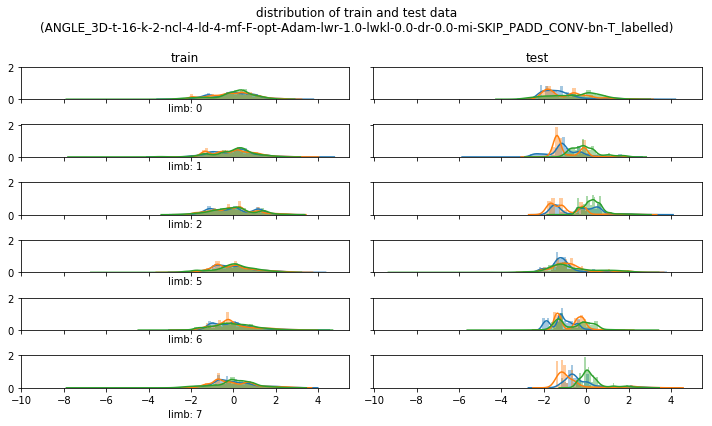

In [15]:
reload(plots)
#
# Making sure that the train/test distributions are not too different from each other
#
if run_cfg['use_time_series']:
    _plt_data_idx_ = np.s_[:, -1, :]
else:
    _plt_data_idx_ = np.s_[:]
    
if run_cfg['data_type'] == data_loading.DataType.ANGLE_3D:
    fig = plots.plot_3d_angle_data_distribution(X_train[_plt_data_idx_],
                                                X_test[_plt_data_idx_],
                                                selected_columns, 
                                                exp_desc=run_cfg.description())
else:
    fig = plots.plot_2d_distribution(data_train[_plt_data_idx_], data_test[_plt_data_idx_], exp_desc=config.config_description(run_config))

# model def

## doc

### Sources:

- https://blog.keras.io/building-autoencoders-in-keras.html (keras autoencoder implementation)
- https://medium.com/the-artificial-impostor/notes-understanding-tensorflow-part-3-7f6633fcc7c7 (temporal block)
- https://stackoverflow.com/questions/46503816/keras-conv1d-layer-parameters-filters-and-kernel-size (refresher on conv layers)
- https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d (refresher on conv layers)
- https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/ (for a good overview over diluted causal convolutions)
- https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf?gi=c5cb3c007035 (general reference)
- https://medium.com/tensorflow/variational-autoencoders-with-tensorflow-probability-layers-d06c658931b7 (VAE with tensorflow probability)

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

The dilated convolution between signal $f$ and kernel $k$ and dilution factor $l$ is defined as:

$$\left(k \ast_{l} f\right)_t = \sum_{\tau=-\infty}^{\infty} k_\tau \cdot f_{t - l\tau}$$

![](./figures/diluted_convolution.png)
![](./figures/WaveNet_gif.gif)

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

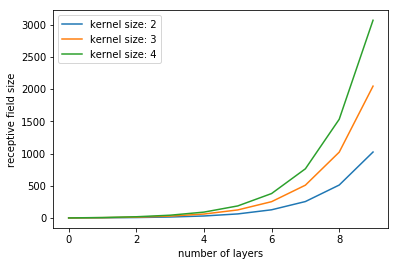

In [16]:
def _receptive_field_size_temporal_conv_net_(kernel_size, n_layers):
    return 1 + 2 * (kernel_size - 1) * (2 ** n_layers - 1)

for k in range(2, 5):
    plt.plot([_receptive_field_size_temporal_conv_net_(kernel_size=k, n_layers=n) for n in range(10)], label=f"kernel size: {k}")
plt.xlabel('number of layers')
plt.ylabel('receptive field size')
plt.legend()

## training

In [17]:
from som_vae.helpers.tensorflow import to_tf_data

from som_vae.training import vae as vae_training
from som_vae.training import supervised as supervised_training

reload(vae_training)
reload(supervised_training)

<module 'som_vae.training.supervised' from '/home/sam/proj/epfl/neural_clustering_vae/som_vae/training/supervised.py'>

In [18]:
def _reshape_and_rescale_(X, scaler=scaler, data_type=run_cfg['data_type']):
    """To be defined in this notebook / function. Basically a larger lambda function
    """
    rescaled = scaler.inverse_transform(X)
    if data_type ==  config.DataType.POS_2D:
        return rescaled.reshape(-1, 15, 2)
    elif data_type ==  config.DataType.ANGLE_3D:
        return rescaled
    else:
        raise ValueError(f"uh, got something odd: {data_type}")

In [19]:
def plot_reconstruction_comparision_angle_3d(X_eval, X_hat_eval, epochs, selected_columns=selected_columns, run_config=run_cfg):
    xticks = np.arange(0, len(X_eval)) / SetupConfig.value('frames_per_second') / 60.
    fig, axs = plt.subplots(nrows=X_eval.shape[1], ncols=1, figsize=(20, 30), sharex=True, sharey=True)
    for i, cn in enumerate(data_loading.get_3d_columns_names(selected_columns)):
        _idx_ = np.s_[:, i]
        axs[i].plot(xticks, X_eval[_idx_], label='input')
        axs[i].plot(xticks, X_hat_eval[_idx_], label='reconstructed')

        axs[i].set_title(cn)

    axs[-1].set_xlabel('time [min]')
    axs[0].legend(loc='upper left')
    
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.suptitle(f"Comparision of selection of data\n({run_config.description()}_e-{epochs})")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.savefig(f"{SetupConfig.value('figures_root_path')}/{run_config.description()}_e-{epochs}_input_gen_recon_comparision.png")

def eval_model(training_results, X, X_eval, run_config):
    model = training_results['model']
    #train_reports = training_results['train_report']
    #test_reports= training_results['test_report']

    exp_desc = run_config.description(short=False)
    exp_desc_short = run_config.description()

    X_hat_eval = _reshape_and_rescale_(model(X, apply_sigmoid=False).numpy()[back_to_single_time])
    
    plot_reconstruction_comparision_angle_3d(X_eval, X_hat_eval, len(training_results['train_reports']))

In [20]:
from hdbscan import HDBSCAN
from collections import namedtuple
from sklearn.manifold import TSNE

LatentSpaceEncoding = namedtuple('LatentSpaceEncoding', 'mean var')

In [21]:
def get_latent_space(model, X):
    if model._name in ['drosoph_vae_conv', 'drosoph_vae_skip_conv']:
        return LatentSpaceEncoding(*map(lambda x: x.numpy(), model.encode(X)))
    else:
        return LatentSpaceEncoding(*map(lambda x: x.numpy()[back_to_single_time], model.encode(X)))

from matplotlib import gridspec

def plot_latent_space(X_latent, X_latent_mean_tsne_proj, y, run_config, epochs):
    labels = np.array([ls.label.name for frame_id, ls in y[back_to_single_time]])
    fig = plt.figure(figsize=(20, 18))
    gs = gridspec.GridSpec(3, 2, figure=fig)
    ax1 = plt.subplot(gs[:2, :])
    ax2 = plt.subplot(gs[-1:, :1])
    ax3 = plt.subplot(gs[-1:, 1:])

    #plt.figure(figsize=(20, 12))
    #fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 30))
    for cluster in np.unique(cluster_assignments):
        c_idx = cluster_assignments == cluster
        sns.scatterplot(X_latent_mean_tsne_proj[c_idx, 0], 
                        X_latent_mean_tsne_proj[c_idx, 1], 
                        label=cluster, 
                        ax=ax1,
                        color=cluster_colors[cluster], 
                        style=labels[c_idx],
                        legend=False)
        sns.scatterplot(X_latent.mean[c_idx, 0], X_latent.mean[c_idx, 1], label=cluster, ax=ax2, legend=False)
        sns.scatterplot(X_latent.var[c_idx, 0], X_latent.var[c_idx, 1], label=cluster, ax=ax3, legend=False)

    ax1.set_title('T-SNE projection of latent space (mean & var stacked)')
    ax2.set_title('mean')
    ax3.set_title('var')
    
    plt.savefig(f"{SetupConfig.value('figures_root_path')}/{run_config.description()}_e-{epochs}_latent_space_tsne.png")

In [22]:
X = np.vstack((X_train, X_test))
y = np.vstack((y_train, y_test))

X_train_dataset= to_tf_data(X_train, batch_size=run_cfg['batch_size'])
X_test_dataset = to_tf_data(X_test, batch_size=run_cfg['batch_size']) 

if run_cfg['use_time_series']:
    back_to_single_time = np.s_[:, -1, :]
else:
    back_to_single_time = np.s_[:]
    
X_eval = _reshape_and_rescale_(X[back_to_single_time])

In [23]:
vae_training_args = vae_training.init(input_shape=X_train.shape[1:], run_config=run_cfg)
vae_training_results = {}

W0612 03:07:38.467590 140501472360256 deprecation_wrapper.py:119] From /home/sam/proj/epfl/neural_clustering_vae/som_vae/training/vae.py:22: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



Using model: ModelType.SKIP_PADD_CONV


/home/sam/.local/opt/miniconda3/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py:174: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(numpy_dtype, np.complex) or


[18 17 16 15 15 14 13 13 12 11 10 10  9  8  8]
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


W0612 03:07:42.073331 140501472360256 deprecation_wrapper.py:119] From /home/sam/proj/epfl/neural_clustering_vae/som_vae/training/vae.py:57: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



Model: "model_1"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_2 (InputLayer)                         [(128, 16, 18)]                         0              
____________________________________________________________________________________________________
inference_net (Sequential)                   (128, 8)                                11564          
____________________________________________________________________________________________________
tf_op_layer_split_1 (TensorFlowOpLayer)      [(128, 4), (128, 4)]                    0              
____________________________________________________________________________________________________
activation_1 (Activation)                    (128, 4)                                0              
Total params: 11,564
Trainable params: 11,186
Non-trainable params: 378
__

In [ ]:
# this allows continuous training with a fixed number of epochs. uuuh yeah.
for _ in range(8):
    vae_training_results = vae_training.train(**{**vae_training_args, **vae_training_results},
                                              train_dataset=X_train_dataset, 
                                              test_dataset=X_test_dataset,
                                              early_stopping=False,
                                              n_epochs=25)

    eval_model(vae_training_results, X, X_eval, run_cfg)
    
    X_latent = get_latent_space(vae_training_results['model'], X)
    X_latent_mean_tsne_proj = TSNE(n_components=2, random_state=42).fit_transform(np.hstack((X_latent.mean, X_latent.var)))

    cluster_assignments = HDBSCAN(min_cluster_size=8).fit_predict(np.hstack((X_latent.mean, X_latent.var)))
    cluster_colors = sns.color_palette(n_colors=len(np.unique(cluster_assignments)))

    plot_latent_space(X_latent, X_latent_mean_tsne_proj, y, run_cfg, epochs=len(vae_training_results['train_reports']))

W0612 03:07:43.012462 140501472360256 deprecation_wrapper.py:119] From /home/sam/proj/epfl/neural_clustering_vae/som_vae/models/drosoph_vae.py:114: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0612 03:07:43.139597 140501472360256 deprecation_wrapper.py:119] From /home/sam/proj/epfl/neural_clustering_vae/som_vae/losses/vae_loss.py:40: The name tf.losses.mean_squared_error is deprecated. Please use tf.compat.v1.losses.mean_squared_error instead.



In [ ]:
#X_train_supervised_dataset = to_tf_data(X_train, preprocessing.frame_label_pair_to_int(y_train), batch_size=run_cfg['batch_size'])
#X_test_supervised_dataset = to_tf_data(X_train, preprocessing.frame_label_pair_to_int(y_train), batch_size=run_cfg['batch_size'])
#
#supervised_training_args = supervised_training.init(run_config=run_cfg)
#supervised_training_results = supervised_training.train(model.inference_net,
#                                                        **supervised_training_args,
#                                                        train_dataset=X_train_supervised_dataset, 
#                                                        test_dataset=X_test_supervised_dataset,
#                                                        early_stopping=False,
#                                                        n_epochs=4)

# evaluation

In [ ]:
#_min_nb_batches_for_sample_length_ = int(np.ceil(len(X) / run_cfg['batch_size']))
#X_gen_eval = np.vstack([model.sample().numpy()  for _ in range(_min_nb_batches_for_sample_length_)])[back_to_single_time]
#X_gen_eval = _reshape_and_rescale_(X_gen_eval[:len(X)])

In [ ]:
## losses
#for a, n in zip(range(train_reports.shape[1]), ['a', 'b', 'c']):
#    plt.subplot(train_reports.shape[1] + 1, 1, a + 1)
#    plt.plot(train_reports[:, a], label=f"train_{n}")
#    plt.plot(test_reports[:, a], label=f"test_{n}")
#    plt.title(n)
#    
#plt.tight_layout()
#plt.legend()

In [ ]:
#plots.plot_losses(train_losses, test_losses, exp_desc=exp_desc);

In [ ]:
#if run_cfg['data_type'] == config.DataType.POS_2D:
#    fig = plots.plot_comparing_joint_position_with_reconstructed(X_eval,
#                                                                 X_hat_eval,
#                                                                 X_gen_eval,
#                                                                 validation_cut_off=n_train_data_points,
#                                                                 exp_desc=exp_desc_short);
#else:
#    # ncols is an ugly hack... it works on the basis that we have three working angles for each leg
#    if run_cfg['use_single_fly']:
#        start = 0
#        end = len(X_eval)
#    else:
#        start = 100
#        end = 1000
#    xticks = np.arange(start, end) / SetupConfig.value('frames_per_second') / 60.
#    if run_cfg['debug']:
#        _input_data = X[:, :, 0]
#        _recon = model(X, apply_sigmoid=False).numpy()[:, :, 0]
#        fig, axs = plt.subplots(nrows=_input_data.shape[-1], ncols=1, figsize=(20, 30), sharex=True, sharey=True)
#        for i in range(_input_data.shape[-1]):
#            _idx_ = np.s_[start:end, i]
#            axs[i].plot(xticks, _input_data[_idx_], label='input')
#            axs[i].plot(xticks, _recon[_idx_], label='reconstructed')
#    else:
#        fig, axs = plt.subplots(nrows=X_eval.shape[1], ncols=1, figsize=(20, 30), sharex=True, sharey=True)
#        for i, cn in enumerate(SD.get_3d_columns_names(selected_cols)):
#            _idx_ = np.s_[start:end, i]
#            axs[i].plot(xticks, X_eval[_idx_], label='input')
#            axs[i].plot(xticks, reconstructed_data[_idx_], label='reconstructed')
#
#            axs[i].set_title(cn)
#
#    axs[-1].set_xlabel('time [min]')
#    axs[0].legend(loc='upper left')
#    
#    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#    plt.suptitle(f"Comparision of selection of data\n({exp_desc})")
#    
#    plt.tight_layout()
#    plt.subplots_adjust(top=0.94)
#    plt.savefig(f"./figures/{exp_desc_short}_input_gen_recon_comparision.png")

# Latent space

In [ ]:
#plot_latent_space(X_latent, X_latent_mean_tsne_proj, y, run_cfg, epochs=len(vae_training_results['train_reports']))

In [ ]:
#from matplotlib.collections import LineCollection
#
#def plot_debug(input_data, cluster_assignments, cluster_colors=None):
#    _clusters = np.unique(cluster_assignments)
#    _colors = sns.color_palette(n_colors=len(_clusters))
#    if cluster_colors is None:
#        cluster_colors = dict(zip(_clusters, _colors))
#        
#    lines, colors = zip(*[([(x, input_data[x, 0]) for x in segment], cluster_colors[cluster_id])
#                           for cluster_id, segments in video.group_by_cluster(cluster_assignments).items() 
#                           for segment in segments])
#
#
#    
#    fig, ax = plt.subplots(figsize=(10, 8))
#    coll = LineCollection(lines, colors=colors)
#    #coll.set_array(np.random.random(xy.shape[0]))
#
#    ax.add_collection(coll)
#    ax.autoscale_view()
#
#    plt.title('Input data and cluster assigment using debug data');
#    
#if run_cfg['debug']:
#    plot_debug(input_data, cluster_assignments)

In [ ]:
# TODO
# use this to add a different shape to the scatter plot
# frames_idx_with_labels[:len(frames_of_interest)][frames_of_interest][run_config['time_series_length'] - 1:]['label'].apply(lambda x: x.value)

# videos

In [ ]:
def reverse_pos_pipeline(x, normalisation_factors):
    """TODO This is again pretty shitty... ultra hidden global variable"""
    return x + normalisation_factors[:x.shape[-1]]

def video_prep_raw_data(data):
    if run_config['use_time_series']:
        return reverse_pos_pipeline(scaler.inverse_transform(data[:, -1, :]).reshape(-1, 15, 2))
    else:
        return reverse_pos_pipeline(scaler.inverse_transform(data.reshape(-1, 30)).reshape(-1, 15, 2))
    
def video_prep_recon_data(input_data):
    return reverse_pos_pipeline(scaler.inverse_transform(model(input_data).numpy()).reshape(-1, 15, 2))

In [ ]:
if run_config['data_type'] == _DATA_TYPE_2D_POS_:
    _positional_data_ = [reverse_pos_pipeline(input_data, normalisation_factors=normalisation_factors), 
                         reverse_pos_pipeline(reconstructed_data, normalisation_factors=normalisation_factors)]
else:
    raise NotImplementedError('give me a break')
    
p = video.comparision_video_of_reconstruction(_positional_data_,
                                              images_paths_for_experiments=images_paths_for_experiments, 
                                              n_train=len(data_train),
                                              cluster_assignments=cluster_assignments,
                                              as_frames=False,
                                              exp_desc=exp_desc_short)

display_video(p)

In [ ]:
# Super ugly... but necessary...
# first there is the time offset due to the slicing
# then there is the concatenation of the data...

angle_data_pos_to_frame = []

for exp_key, data in angle_data_raw: 
    _exp = SD._experiment_from_key_(exp_key)
    
    if len(angle_data_pos_to_frame) == 0:
        _idx = np.arange(data.shape[0])[run_config['time_series_length'] - 1:]
    else:
        _idx = np.arange(data.shape[0])# + len(angle_data_pos_to_frame)
        
    angle_data_pos_to_frame += [(_exp, d) for d in _idx]

In [ ]:
        images_paths_for_experiments = settings.data.EXPERIMENTS.map(lambda x: (x, config.positional_data(x)))\
                                               .flat_map(lambda x: [(x[0], config.get_path_for_image(x[0], i)) for i in range(x[1].shape[1])])\
                                               .to_list()

In [ ]:

    frames_idx_with_labels = preprocessing.get_frames_with_idx_and_labels(settings.data.LABELLED_DATA)
    frames_of_interest = ~frames_idx_with_labels['label'].isin([settings.data._BehaviorLabel_.REST])

In [ ]:
images_paths_for_experiments = [(exp, config.get_path_for_image(exp, i)) for exp, i in angle_data_pos_to_frame]

In [ ]:
images_paths_for_experiments[-10:]

In [ ]:
reload(video)
from collections import OrderedDict
_N_CLUSTER_TO_VIZ_ = 10
_t = [(misc.flatten(sequences), cluster_id) for cluster_id, sequences in video.group_by_cluster(cluster_assignments).items()]
_t = sorted(_t, key=lambda x: len(x[0]), reverse=True)

cluster_colors = sns.color_palette(n_colors=len(np.unique(cluster_assignments)))

cluster_vids = OrderedDict((p[1], video.comparision_video_of_reconstruction(input_data,
                                                                            cluster_assignments=cluster_assignments,
                                                                            images_paths_for_experiments=images_paths_for_experiments,
                                                                            n_train=data_train.shape[0],
                                                                            cluster_colors=cluster_colors,
                                                                            cluster_id_to_visualize=p[1], 
                                                                            exp_desc=exp_desc_short,
                                                                            is_2d=False))
                    for p in _t[:_N_CLUSTER_TO_VIZ_])

print('cluster_vids: ', cluster_vids.keys())

In [ ]:
! cat ./som_vae/helpers/video.py

In [ ]:
from collections import OrderedDict
_N_CLUSTER_TO_VIZ_ = 10
_t = [(misc.flatten(sequences), cluster_id) for cluster_id, sequences in video.group_by_cluster(cluster_assignments).items()]
_t = sorted(_t, key=lambda x: len(x[0]), reverse=True)

cluster_colors = sns.color_palette(n_colors=len(np.unique(cluster_assignments)))

cluster_vids = OrderedDict((p[1], video.comparision_video_of_reconstruction(_positional_data_,
                                                                      cluster_assignments=cluster_assignments,
                                                                      images_paths_for_experiments=images_paths_for_experiments,
                                                                      n_train=data_train.shape[0],
                                                                      cluster_colors=cluster_colors,
                                                                      cluster_id_to_visualize=p[1], exp_desc=exp_desc_short))
                    for p in _t[:_N_CLUSTER_TO_VIZ_])

print('cluster_vids: ', cluster_vids.keys())

In [ ]:
#c_idx = 0
c_idx += 1
display_video(list(cluster_vids.values())[c_idx])

In [ ]:
c_idx = 0
#c_idx += 1
display_video(list(cluster_vids.values())[c_idx])

In [ ]:
images_paths_for_experiments

In [ ]:
len(np.where(cluster_assignments == 11)[0])

In [ ]:
np.array(images_paths_for_experiments)

In [ ]:
for fs, c in _t:
    print(f"cluster {c} has {len(fs)} elements")

In [ ]:
reload(video)

_t = [(misc.flatten(sequences), cluster_id) for cluster_id, sequences in video.group_by_cluster(cluster_assignments).items()]
_t = sorted(_t, key=lambda x: len(x[0]), reverse=True)
p = video.video_angle(cluster_assignments, images_paths_for_experiments, cluster_id_to_visualize=_t[3][1], exp_desc=exp_desc_short)

In [ ]:
display_video(p)

In [ ]:
stop

# Convolution Clarification

Below are the results shown for a Conv1d for all padding options:

- valid: only convolutions where the kernel fits inside the input are comptued
- causal: input is shifted such that the kernel can only see itself and backwards in time
- same: input is padded such that the convolution can also be applied to the border cases

kernel sizes of 2 & 3, and dilation rates for 1 to 3.

The result is that a valid convolution of kernel size 2 with a dilation factor of 1 compresses the input in a for us good way.
The data goes from `[batch_size, n_time_steps, n_channels]` to `[batch_size, n_time_steps - 1, n_filters]` 
and crops the first time step only. Thus building features by only looking backwards in time,
dropping the first-time step. Thus features are build over time and space.

In [ ]:
example_data = np.zeros((1, 10, 5), dtype=np.float32)

for row in range(example_data.shape[1]):
    example_data[:, row, :] = row
    
example_data

In [ ]:
def conv_clarification_kernel(kernel_size):
    conv1d_kernel_no_time = np.zeros((kernel_size, example_data.shape[-1], 1), dtype=np.float32)
    conv1d_kernel_no_time[0, :, :] = .5
    conv1d_kernel_no_time[1, :, :] = 1.
    
    if kernel_size == 3:
        conv1d_kernel_no_time[2, :, :] = 0.1
    
    return conv1d_kernel_no_time


for kernel_size in range(2, 4):
    print(f"data\n{example_data}")
    print(f"kernel\n{conv_clarification_kernel(kernel_size)}")
    for padding in ['valid', 'causal', 'same']:
        for dilation in range(1, 4):
            example_conv1d = tfkl.Conv1D(filters=1, 
                                         kernel_size=kernel_size,
                                         use_bias=False, 
                                         padding=padding,
                                         dilation_rate=dilation,
                                         kernel_initializer=tf.constant_initializer(conv_clarification_kernel(kernel_size)))

            conv_res = example_conv1d(example_data).numpy()
            print(f"padding: {padding}, dilation_rate: {dilation}, kernel_size: {kernel_size}, output shape: {conv_res.shape}\n{conv_res}")

In [ ]:
def conv_clarification_kernel(kernel_size):
    conv1d_kernel_no_time = np.zeros((kernel_size, example_data.shape[-1], example_conv1d_n_filters), dtype=np.float32)
    conv1d_kernel_no_time[0, :, :] = .5
    conv1d_kernel_no_time[1, :, :] = 1.
    
    if kernel_size == 3:
        conv1d_kernel_no_time[2, :, :] = 0.1
    
    return conv1d_kernel_no_time

kernel_size = 2
padding = 'valid'
dilation_rate = 1
example_conv1d_n_filters = 2

print(f"data\n{example_data}")
print(f"kernel\n{conv_clarification_kernel(kernel_size)}")
example_conv1d = tfkl.Conv1D(filters=example_conv1d_n_filters, 
                             kernel_size=kernel_size,
                             use_bias=False, 
                             padding=padding,
                             dilation_rate=dilation_rate,
                             kernel_initializer=tf.constant_initializer(conv_clarification_kernel(kernel_size)))

example_max_pooling_layer = tfkl.MaxPool1D()
example_dense = tfkl.Dense(2, use_bias=False, kernel_initializer='ones')

conv_res = example_conv1d(example_data[:,:2,:]).numpy()
#max_pool_res = example_max_pooling_layer(conv_res)
#dense_res = example_dense(max_pool_res)
print(f"padding: {padding}, dilation_rate: {dilation_rate}, kernel_size: {kernel_size}, output shape: {conv_res.shape}")
print('conv\n', conv_res)
#print('max pool\n', max_pool_res.numpy())
#print('dense\n', dense_res.numpy())

In [ ]:
conv_res

In [ ]:
class Conv1D_Transpose(tfkl.Layer):
    def __init__(self, n_filters, kernel_size, batch_size):
        super(Conv1D_Transpose, self).__init__()        
        self.n_filters = n_filters
        self.batch_size = batch_size
        self.conv2d_transpose = tfkl.Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, strides=2, padding='valid', kernel_initializer='ones')
        
    def call(self, inputs):
        x = tf.reshape(inputs, [self.batch_size, 1, *inputs.shape[1:]])
        print(x.shape)
        x = self.conv2d_transpose(x)
        #x = tf.reshape(x, [self.batch_size, -1, self.n_filters])
        
        return x

example_deconv1d = Conv1D_Transpose(n_filters=2, kernel_size=2, batch_size=1)
example_deconv1d(conv_res)

In [ ]:
_ted = example_deconv1d(conv_res)
tf.reshape(_ted, _ted.shape[:-1])

In [ ]:
UpsamplingConv(2)(conv_res)

In [ ]:
tfkl.UpSampling1D(3)(conv_res)

In [ ]:
class UpsamplingConv(tfkl.Layer):
    def __init__(self, n_filters, kernel_size=2):
        super(UpsamplingConv, self).__init__()
        
        self.n_filters = n_filters
        self.kernel_size = kernel_size
    
    def call(self, x): 
        x = tfkl.UpSampling1D(3)(x) # upscale with 3 so that we can again apply `valid` padding and "reverse" the encoder
        print(x.shape)
        # TODO maybe add some fancy flipping of the input
        x = tfkl.Conv1D(self.n_filters, self.kernel_size, padding='valid')(x)
        
        return x

In [ ]:
conv_res.shape

In [ ]:
conv_res

In [ ]:
example_deconv = tfkl.Conv2DTranspose(1, 2, kernel_initializer='ones')
example_deconv(conv_res.reshape(-1, 1, *conv_res.shape[1:])).numpy().reshape(-1, *conv_res.shape[1:])

In [ ]:
conv_res

In [ ]:
conv_res.shape

In [ ]:
conv_res

In [ ]:
tf.rank(conv_res)

In [ ]:
paddings = [[r, 0] for r in range(3)]
paddings

In [ ]:
tf.pad(conv_res, [[0, 0], [0, 1], [0, 0]])

In [ ]:
tfc.nn.conv1d_transpose(input=conv_res, filters=np.ones((2, 2, 2), dtype=np.float32), output_shape=[1, 2, 2], strides=1, padding='VALID')

In [ ]:
_pdc1dt = PaddedConv1dTransposed(n_filters=2)
print(conv_res.shape)
resc1 = _pdc1dt(conv_res)
print(resc1.shape)
resc1.numpy()

In [ ]:
_pdc1dt(_pdc1dt(resc1))

In [ ]:
#_t_layer_sizes_generative=[4,6,8,10,12,14,16,18]
#_t_layer_sizes_generative=[1] * 6
#_t_upsampling_size = [4] * 6 #, 2, 2]
#_t_strides = [2] * 6
##_t_padding = ['valid', 'valid', 'same']
##_t_layer_sizes_generative=[4, 8, 16]
#_latent_dim = 2
#_t_generative_net = tf.keras.Sequential([tfkl.InputLayer(input_shape=(_latent_dim,)),
#                                           tfkl.Lambda(lambda x: tf.reshape(x, [1000, 1, _latent_dim])),
#                                           *[TemporalUpsamplingConv(conv_n_filters=fs, 
#                                                                    upsampling_size=us,
#                                                                    conv_strides=s,
#                                                                    conv_padding='valid',
#                                                                    name=f"gen_conv_{i}") for i, (fs, us, s) 
#                                             in enumerate(zip(_t_layer_sizes_generative,
#                                                              _t_upsampling_size,
#                                                              _t_strides,
#                                                             ))]],
#                                          name='generative_net')
#
#_t_generative_net.summary()